In [1]:
import numpy as np
import sys
import random
import matplotlib.pyplot as plt

In [31]:
imaging_rate = 2.145 #in Hz
num_blocks = 5
approx_exp_dur = 30 #in minutes
inter_block_dur = 30 #in sec
post_stim_dur = 2e3 #in ms
inter_stim_id = 'grey'
seed = random.randrange(1234567890)
stimuli_master = []
time = 0

stimuli = [
    ('grating l', 1e3), ('grating u' , 1e3), ('grating r', 1e3), ('grating d', 1e3),
    ('loom', 1e3), ('moving object', 1e3), ('light flash', 1e3), ('dark flash', 1e3)
]

In [32]:
all_stim_dur = sum(_[1] for _ in stimuli) #add durations of all stimuli together
all_grey_stim_dur = len(stimuli) * post_stim_dur #total time of grey for one stim cycle
all_inter_block_grey_dur = (num_blocks + 1) * inter_block_dur #total time of grey between blocks

block_dur = (approx_exp_dur * 60 - all_inter_block_grey_dur / 1e3) / num_blocks #duration of one block

#how many times each stim can be displayed in a block
num_cycles = int(np.floor(block_dur / (all_stim_dur / 1e3 + all_grey_stim_dur / 1e3)))

#amount to shift stimulus onset relative to imaging to end up with even imaging coverage for each stimuli
shift_len = (1 / imaging_rate) / num_cycles

In [33]:
#set random state
r = np.random.RandomState(seed)

In [34]:
stimuli_master.append((inter_stim_id, time)) #add grey
time += inter_block_dur * 1e3 #update time based on inter block duration

#create list of desired shifts (these shifts evenly cover the space between imaging time points)
shifts_master = [num * (shift_len * 1e3) for num in list(range(1,num_cycles))]

In [35]:
#### MAKE BLOCK LOOP

In [36]:
#should each block have the same exact stimtime/imaging time shift? I think I will try without that.

for block in range(num_blocks):
    #create a list of shuffled stimuli ids
    stim_ids = list(range(len(stimuli)))
    stim_ids_shuff_first = list(r.permutation(stim_ids))

    first_stim = []

    #append first cycle of stimuli 
    for i in stim_ids_shuff_first:
        stimuli_master.append((stimuli[i][0], time))
        first_stim.append((stimuli[i][0], time))
        time += stimuli[i][1]
        stimuli_master.append((inter_stim_id, time))
        time += post_stim_dur

    #Each stimuli needs a random version of shifts_master
    shifts_shuff = []
    shifts_shuff.append([list(r.permutation(shifts_master)) for stim in range(len(stimuli))])
    shifts_shuff = shifts_shuff[0] #remove outer added list layer
    #now shifts_shuff[i] gives the stimulus order for the ith stimuli

    for cycle in range(num_cycles-1):
        stim_ids_shuff = list(r.permutation(stim_ids))
        for stim in stim_ids_shuff:
            #find index for the desired stim in the first stim list
            stim_loc = int(np.where(np.asarray(stim_ids_shuff_first) == stim)[0])

            #find time the stim was first displayed
            stim1 = first_stim[stim_loc][1]

            #based on imaging rate, if stim were displayed now, calculate the stim offset from its first display
            stim_offset = (time - stim1) % (1 / imaging_rate * 1e3)

            #how much grey delay to add
            #NOTE: CHANGE 0 each loop
            #print('cycle:', cycle)
            delay_to_add = shifts_shuff[stim][cycle] - stim_offset

            if delay_to_add < 0:
                delay_to_add += 1 / imaging_rate * 1e3

            time += delay_to_add

            stimuli_master.append((stimuli[stim][0], time))

            time += stimuli[stim][1]
            stimuli_master.append((inter_stim_id, time))
            time += post_stim_dur
            
    stimuli_master.append((inter_stim_id, time)) #add inter block grey
    time += inter_block_dur * 1e3 #update time based on inter block duration
    time += r.randint(0,2000) #extend grey by random amount - helps keep blocks independent
    
times = [ _[1] for _ in stimuli_master]
dur = list(np.diff(times))
dur.append(inter_block_dur * 1e3)
stim = [ _[0] for _ in stimuli_master]

In [38]:
shifts_master

[33.3000333000333,
 66.6000666000666,
 99.90009990009989,
 133.2001332001332,
 166.5001665001665,
 199.80019980019978,
 233.10023310023308,
 266.4002664002664,
 299.7002997002997,
 333.000333000333,
 366.3003663003663,
 399.60039960039956,
 432.90043290043286]

In [17]:
np.shape(shifts_shuff)

(8, 7)

In [16]:
shifts_shuff

[[58.27505827505827,
  291.37529137529134,
  174.82517482517483,
  407.9254079254079,
  116.55011655011654,
  233.10023310023308,
  349.65034965034965],
 [349.65034965034965,
  174.82517482517483,
  233.10023310023308,
  116.55011655011654,
  407.9254079254079,
  58.27505827505827,
  291.37529137529134],
 [291.37529137529134,
  233.10023310023308,
  349.65034965034965,
  58.27505827505827,
  407.9254079254079,
  116.55011655011654,
  174.82517482517483],
 [233.10023310023308,
  407.9254079254079,
  349.65034965034965,
  58.27505827505827,
  291.37529137529134,
  116.55011655011654,
  174.82517482517483],
 [233.10023310023308,
  58.27505827505827,
  174.82517482517483,
  407.9254079254079,
  349.65034965034965,
  291.37529137529134,
  116.55011655011654],
 [233.10023310023308,
  407.9254079254079,
  58.27505827505827,
  116.55011655011654,
  291.37529137529134,
  174.82517482517483,
  349.65034965034965],
 [116.55011655011654,
  407.9254079254079,
  174.82517482517483,
  349.65034965034

In [27]:
num_cycles

14

In [26]:
np.shape(shifts_shuff)

(8, 7)

In [116]:
times = [ _[1] for _ in stimuli_master]
dur = list(np.diff(times))
dur.append(inter_block_dur * 1e3)
dur[-5:]
len(dur)


646

In [117]:
len(stim)

646

In [106]:
times = [ _[1] for _ in stimuli_master]
stim = [ _[0] for _ in stimuli_master]

In [112]:
stim[-5:]

['grating u', 'grey', 'grating l', 'grey', 'grey']

In [113]:
dur[-5:]

[4466.2004662004765, 1000.0, 4407.925407925388, 1000.0, 4000.0]

In [109]:
dur = list(np.diff(times))
len(dur)

645

In [29]:
loomtimes = np.asarray([ _[1] for _ in stimuli_master if _[0] == 'loom'])

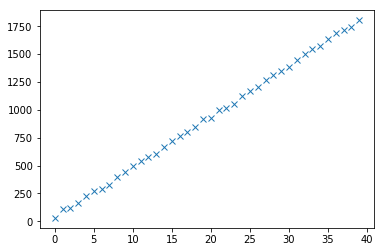

In [30]:
plt.plot(loomtimes/1e3, 'x')

70


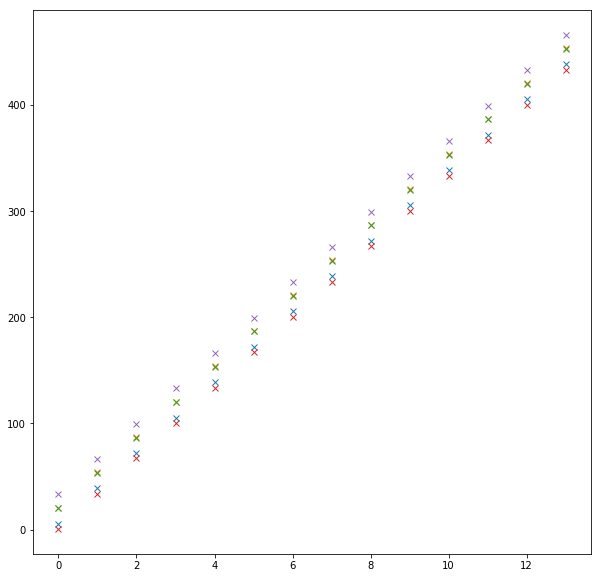

In [40]:
### Code for testing correct stimulus spacing ###

temp = list(range(100000))
image_times = [ _ * (1 / imaging_rate * 1e3) for _ in temp]
stim_list = [stim[0] for stim in stimuli_master]

fig = plt.figure(figsize=(10,10))
stim_names = [stimuli[name][0] for name in range(len(stimuli))]
for name in ['loom']:
    stim = list(np.where(np.asarray(stim_list) == name)[0])
    times = [stimuli_master[stim][1] for stim in stim]
    print(len(times))
    for block in range(num_blocks):
        delays_test = []
        for stim_time in times[block*num_cycles:block*num_cycles+num_cycles]:
            for i in range(len(image_times)):
                if stim_time < image_times[i]:
                    delays_test.append(stim_time-image_times[i-1])
                    break
        plt.plot(sorted(delays_test, key=int),'x')

70


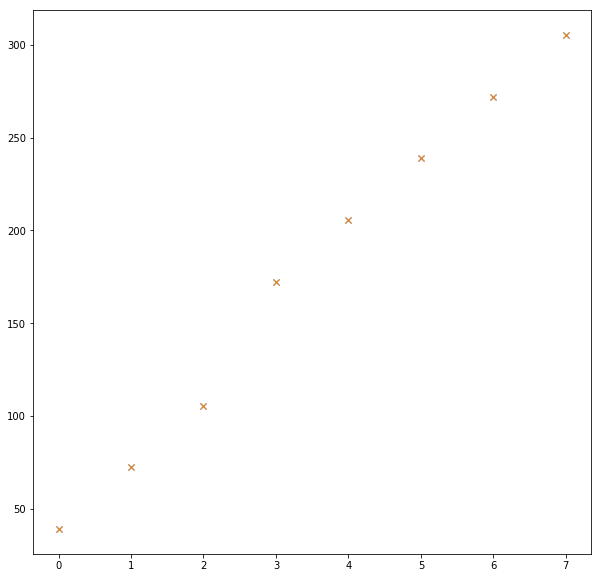

In [38]:
### Code for testing correct stimulus spacing ###

temp = list(range(100000))
image_times = [ _ * (1 / imaging_rate * 1e3) for _ in temp]
stim_list = [stim[0] for stim in stimuli_master]

fig = plt.figure(figsize=(10,10))
stim_names = [stimuli[name][0] for name in range(len(stimuli))]
for name in ['loom']:
    stim = list(np.where(np.asarray(stim_list) == name)[0])
    times = [stimuli_master[stim][1] for stim in stim]
    print(len(times))
    for block in range(2):
        delays_test = []
        for stim_time in times[:8]:
            for i in range(len(image_times)):
                if stim_time < image_times[i]:
                    delays_test.append(stim_time-image_times[i-1])
                    break
        plt.plot(sorted(delays_test, key=int),'x')

In [ ]:
### Code for testing correct stimulus spacing ###

temp = list(range(10000))
image_times = [ _ * (1 / imaging_rate * 1e3) for _ in temp]
stim_list = [stim[0] for stim in stimuli_master]

fig = plt.figure(figsize=(10,10))
stim_names = [stimuli[name][0] for name in range(len(stimuli))]
for name in stim_names:
    stim = list(np.where(np.asarray(stim_list) == name)[0])
    times = [stimuli_master[stim][1] for stim in stim]
    delays_test = []
    for stim_time in times:
        for i in range(len(image_times)):
            if stim_time < image_times[i]:
                delays_test.append(stim_time-image_times[i-1])
                break
    plt.plot(sorted(delays_test, key=int),'x')

In [9]:
# for i in stim_ids_shuff:
#     stim_loc = int(np.where(np.asarray(stim_ids_shuff_first) == i)[0])
#     stim1 = first_stim[stim_loc][1]
#     stim2 = stim1 - time
#     stim_offset = (stim2 - stim1) % (1 / imaging_rate)
#     stimuli_master.append((stimuli[i][0], time))